In [22]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io

Setup for processing

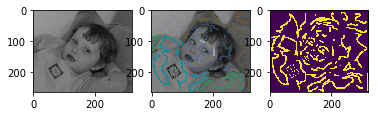

(265, 320)


In [65]:
g_name = cv2.imread('example.bmp') 

plt.subplot(131)
plt.imshow(g_name)

c_name = cv2.imread('example_marked.bmp') 
plt.subplot(132)
plt.imshow(c_name)

gI = np.copy(g_name).astype('float64')/255
cI = np.copy(c_name).astype('float64')/255
colorIm = (np.sum(abs(gI-cI), 2)>0.01)
colorIm = colorIm.astype('float64')
plt.subplot(133)
plt.imshow(colorIm)
plt.show()
print colorIm.shape

(265, 320, 3)


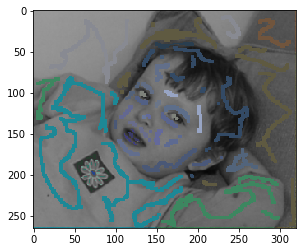

In [60]:
# myimage = cv2.imread('gili_m.png') # read image in as BGR need to convert to YUV
# myimage = io.imread('https://www.cs.huji.ac.il/~yweiss/Colorization/gray/gili_m.bmp') # reading image from research paper
myimage=c_name
print image_m.shape
plt.imshow(myimage)
plt.show()

(265, 320, 3)


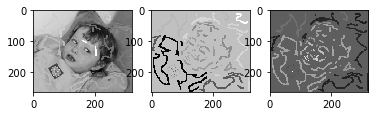

In [73]:
sgI=cv2.cvtColor(g_name,cv2.COLOR_BGR2YUV)
sgI= sgI.astype('float64')/255
scI=cv2.cvtColor(c_name,cv2.COLOR_BGR2YUV)
scI= scI.astype('float64')/255
print scI.shape  # background on yuv https://en.wikipedia.org/wiki/YUV

y=scI[:,:,0] # intensity
plt.subplot(131)
plt.imshow(y, cmap='gray')
u=scI[:,:,1] # color
plt.subplot(132)
plt.imshow(u, cmap='gray')
v= scI[:,:,2] # color
plt.subplot(133)
plt.imshow(v, cmap='gray')
plt.show()

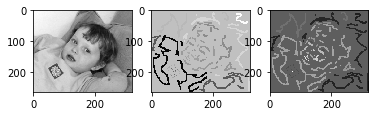

In [76]:
ntscIm= np.zeros(g_name.shape)
ntscIm[:,:,0]=sgI[:,:,0]
ntscIm[:,:,1]=scI[:,:,1]
ntscIm[:,:,2]=scI[:,:,2]
y=ntscIm[:,:,0] # intensity
plt.subplot(131)
plt.imshow(y, cmap='gray')
u=ntscIm[:,:,1] # color
plt.subplot(132)
plt.imshow(u, cmap='gray')
v= ntscIm[:,:,2] # color
plt.subplot(133)
plt.imshow(v, cmap='gray')
plt.show()